In [3]:
import math
import numpy as np, random
from typing import Tuple
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## 一、問題描述與模型設定

---

### 1. 賭徒破產問題（Gambling Problem）

* **參與者**：Alice (玩家)與 Bob (莊家) 對賭

* **起始資金**：

  * 玩家 的起始資金為 \$a
  
  * 莊家 的起始資金為 \$b
  
* **總資金**：

  $m = a + b$

  因此 莊家 的資金亦可寫成 $\$(m–a)$。
  
* **下注規則**：每一步（step）兩人各下注 \$1，勝負結果為：

  * 以機率 $p$，玩家 從 莊家 那裡贏得 \$1（玩家 資金 +1，莊家 資金 –1）
  * 以機率 $q=1-p$，莊家 從 玩家 那裡贏得 \$1（莊家 資金 +1，玩家 資金 –1）
  
* **遊戲結束**：當任一方資金歸零，即該方破產（ruined），遊戲終止。
---

## 2. 模型設定（Gambler’s Ruin Markov Chain）

#### 定義離散隨機過程 $\{X_n\}_{n\in\mathbb{Z}_+}$，其中 $\mathbb{Z}_+ = \{0,1,2,\dots\}$


  $$
    X_n = \text{第 }n\text{ 步後，玩家 持有的資金}
  $$

  則 莊家 此時擁有的資金為 $m - X_n$。
#### 狀態空間：

  $$
    S = \{0,1,2,\dots,m\},
  $$

  其中
  * 初始條件(玩家 起始資本): $X_0 = a$
  * $X_n=0$：玩家 破產（吸收態）
  * $X_n=m$：玩家 獲勝，莊家 破產（吸收態）
  * 其餘 $1 \le X_n \le m-1$ 為暫態。
  
#### 轉移機率 (當 $1 \le i \le m-1$ 時）：

$
  X_{n+1} =
  \begin{cases}
    X_n + 1, & \text{機率 } p\\
    X_n - 1, & \text{機率 } q
  \end{cases}
$

$$
    P(X_{n+1}=i+1 \mid X_n=i) = p,\quad
    P(X_{n+1}=i-1 \mid X_n=i) = q.
$$
  
#### 吸收態：

$
  X_{n+1} =
  \begin{cases}
    0, & \text{若 } X_n = 0\ (\text{玩家 破產}),\\
    m, & \text{若 } X_n = m\ (\text{玩家 贏得全部資金，莊家 破產}).
  \end{cases}
$

$$
    P(X_{n+1}=0\mid X_n=0)=1,\qquad
    P(X_{n+1}=m\mid X_n=m)=1.
$$

---


* **示意圖**:
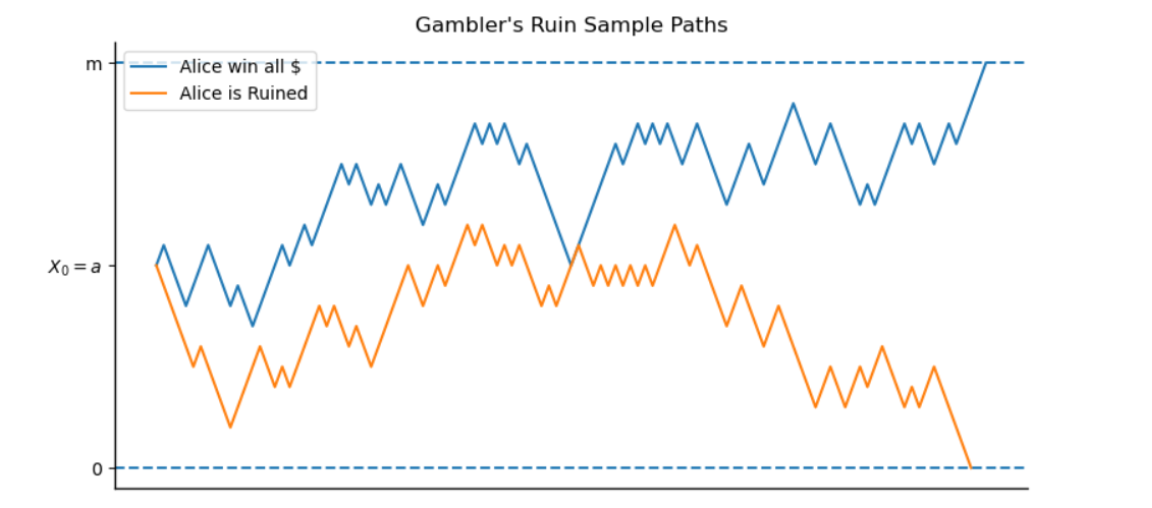

# Q1. 遊戲以玩家破產結束的機率是多少？

令 $r_i$ 表示當 玩家 目前擁有 $i$ 時，最終破產(ruin)的機率

* $r_a$ (假設玩家的起始資金為 \$a$ 的情況下，最終破產機率之符號的表示方式)

* $r_i :=\begin{cases}r_0 = 1, \text{必定破產},\\[6pt]p \cdot r_{i+1} + q \cdot r_{i-1}, & 1 \le i \le m-1,\\[6pt]r_m = 0,\text{擁有所有的錢, 不會破產}.\end{cases}$

## 該問題為對 Homogeneous Linear Difference Equation的求解:

### $$p\cdot r_{i+1} - r_i + q\cdot r_{i-1} = 0,\quad r_0 = 1,\quad r_m = 0$$

### 經推導求解後，其結果為以下:

$ \boxed{\text{Case I}} \quad : \quad (p \neq q) : 不公平賭局之情形$



$ r_i = \frac{\left( \frac{q}{p} \right)^i - \left( \frac{q}{p} \right)^m}{1 - \left( \frac{q}{p} \right)^m} $



$ \text{令 } \rho = \frac{q}{p} \quad \Rightarrow \quad r_i = \frac{\rho^i - \rho^m}{1 - \rho^m} $





$ \boxed{\text{Case II}} \quad : \quad (p = q) : 公平賭局之情形$



$ r_i = 1 - \frac{i}{m} $

In [13]:
def analytical_ruin(i: int, m: int, p: float) -> float:
    '''
    輸入：
        i：Alice 的初始資金（當前資金），整數，且 $0\le i\le m$
        m：玩家 + 莊家 的總資金（吸收態為 0 與 m）
        p：Alice 每步下注贏取 1 元的機率

    輸出：
        r_i：Alice 從資金 $i$ 開始，最終被吸收到「破產」（資金＝0）的機率（即 Alice 最終的破產機率）。
    '''
    
    q = 1 - p
    
    # 處理公平賭局(p=q)的情況
    if abs(p - q) < 1e-9:
        return 1- (i / m)
    
    
    # 處理非公平賭局(p≠q)的情況
    rho = q / p
    r_i = (rho**i - rho**m) / (1 - rho**m)
    return r_i

# Q2. 此遊戲平均 (average) 會持續多久？

$\text{令 }d_i\text{ 表示當 玩家 目前擁有 }\$i\text{ 時，遊戲期望持續時間(回合數) }$

* $d_a$ (假設玩家的起始資金為 \$a 的情況下，平均遊戲回合數之符號的表示方式)

* $d_i :=\begin{cases}d_0 = 0, \text{玩家此時必定破產 , game over 遊戲結束},\\[6pt]d_i = 1 + p \cdot d_{i+1} + q \cdot d_{i-1}, & 1 \le i \le m-1,\\[6pt]d_m = 0, \text{玩家贏得所有的資金 ,  game over 遊戲結束}.\end{cases}$

## 該問題為對 Inhomogeneous Linear Difference Equation的求解:
### $$p\cdot d_{i+1} - d_i + q\cdot d_{i-1} = -1,\quad d_0 = 0,\quad d_m = 0$$

### 經推導求解後，其結果為以下:

$ \boxed{\text{Case I}} \quad : \quad (p \neq q) : 不公平賭局之情形$

$d_i = \frac{i}{q-p} - \frac{m}{q-p} \cdot \frac{1 - \left( \frac{q}{p} \right)^i}{1 - \left( \frac{q}{p} \right)^m}$

$\text{令 } \rho = \frac{q}{p} \quad \Rightarrow \quad d_i = \frac{i}{q-p} - \frac{m}{q-p} \cdot \frac{1 - \rho^i}{1 - \rho^m}$


$ \boxed{\text{Case II}} \quad : \quad (p = q) : 公平賭局之情形$

$ d_i = i \cdot (m-i) $

In [15]:
def expected_duration(i: int, m: int, p: float) -> float:
    """
    計算 Gambler's Ruin 的期望遊戲長度 d_a
    - i: 玩家初始資金
    - m: 玩家 + 莊家 總資金
    - p: 單步玩家勝率
    """
    q = 1 - p
    # 當 p = q = 0.5 時，閉式解為 i * (m - i)
    if math.isclose(p, q):
        return i * (m - i)
    # 否則使用閉式解公式
    rho = q / p
    numerator = i - m * (1 - rho**i) / (1 - rho**m)
    return numerator / (q - p)

# Monte Carlo 模擬

**1. Monte Carlo 模擬介紹**

> 在無法或不便直接推導出複雜模型解析解時，Monte Carlo 模擬提供一種「用大量隨機實驗逼近真實分佈」的方法。本專案中，我們透過 Monte Carlo 模擬「重複進行」Gambler’s Ruin 遊戲，統計玩家最終破產（或贏光莊家）之頻率，以及平均遊戲步數，以驗證解析解並觀察分佈特性。

---

**2. 使用 Monte Carlo 模擬的原因**

* **驗證差分方程閉式解**
  透過大量隨機實驗，統計玩家最終破產機率 $\hat r_i$ 與解析式

  以及平均遊戲步數 $\hat d_i$ 是否吻合，確認 `analytical_ruin` 與 `expected_duration` 所算結果是否正確收斂。

* **分佈特性觀察**
  除了比對期望值，計算「破產機率($r_i$)的信賴區間 與「平均遊戲步數($d_i$)的信賴區間」，量化不確定性。


---

**3. 期望觀察的結果**

* **破產機率**：實驗中玩家最終破產的比例應接近解析值 $r_a$。
* **平均遊戲步數**：所有試驗中遊戲步數的平均值應接近 $d_a$。

---




## 1. Monte Carlo 的數學一般性介紹

**(a) 目標期望**  
$$
I = E_f\bigl[h(X)\bigr] 
  = \int_X h(x)\,f(x)\,\mathrm{d}x
  \quad(\text{離散時為 } \sum_x h(x)\,p(x)).
$$

---

**(b) 核心三步驟**  
1. **抽樣 (Sampling)**  
   產生  
   $$ x_1, x_2, \dots, x_n \;~ iid\; f(x). $$
2. **函數轉換 (Function Evaluation)**  
   計算  
   $$ y_j = h(x_j), \quad j=1,\dots,n. $$
3. **樣本平均 (Sample Mean)**  
   $$ \bar{h}_n = \frac{1}{n} \sum_{j=1}^n y_j \approx E_f[h(X)]. $$

---

**(c) 理論性**  
1. **無偏性**  
   $$ E[\bar{h}_n] = E_f[h(X)]. $$
2. **大數法則應用**  
   $$
     \bar{h}_n
     = \frac{1}{n}\sum_{j=1}^n h(x_j)
     \xrightarrow{\text{a.s.}}
     E_f[h(X)],\quad n\to\infty.
   $$
3. **變異數**  
   $$
     \mathrm{Var}(\bar{h}_n)
     = \frac{1}{n}\,\mathrm{Var}_f[h(X)], 
     \quad
     v_n = \frac{1}{n-1}\sum_{j=1}^n (y_j - \bar{h}_n)^2 \approx \mathrm{Var}_f[h(X)].
   $$
4. **中心極限定理 (CLT)**

   對大 $n$，  
   
   $$\bar{h}_n \;\overset{d}{\approx}\;\mathcal{N}\!\Bigl(E_f[h(X)], \;\tfrac{1}{n}\mathrm{Var}_f[h(X)]\Bigr).$$
   
   可據此構造信賴區間：  
   
   $$\bar{h}_n \pm z_{1-\alpha/2}\,\sqrt{\frac{v_n}{n}}.$$

---

**(d) ECDF 收斂到 CDF（直覺性概念）**  
定義經驗累積分佈函數 (ECDF)：  
$$
  \hat{F}_n(t)
  = \frac{1}{n}\sum_{j=1}^n I\bigl(x_j \le t\bigr),
$$  
其中  
$$
  I(x_j \le t) =
  \begin{cases}
    1, & x_j \le t,\\
    0, & x_j > t.
  \end{cases}
$$  
由 Law of large numbers 得  
$$
  \hat{F}_n(t)
  \xrightarrow{\text{a.s.}}
  F(t)
  = \Pr(X \le t),
$$  
即當樣本數夠大時，ECDF 幾乎必然收斂到真實的 CDF。

---

## 2. 賭徒破產問題下的 Monte Carlo

**(a) 模型設定**  
- 狀態空間： $S=\{0,1,\dots,m\}$，初始資金 $X_0=i$.

- 轉移規則：  

  $$ X_{n+1} =\begin{cases}X_n + 1, & \text{機率 }p\\ X_n - 1, & \text{機率 }q = 1 - p.\end{cases}$$
  
- 吸收態：$X_n = 0$（破產）或 $X_n = m$（勝利）。

---

**(b) 定義待估計量**  
對第 $j$ 條獨立模擬路徑，令  
- 吸收時間：  
  $$ T_j = \min\{n \ge 0 : X_n \in \{0,m\}\}. $$
- 破產指示：  
  $$ R_j = I(X_{T_j} = 0). $$

---

**(c) Monte Carlo 估計量**  
做 $N$ 次模擬後，定義  
$$
  \hat r_i
  = \frac{1}{N}\sum_{j=1}^N R_j
  \;\approx\; r_i
  = \Pr(\text{破產}\mid X_0 = i),
$$  
$$
  \widehat{E[T]}
  = \frac{1}{N}\sum_{j=1}^N T_j
  \;\approx\; E_i[T].
$$

---

**(d) 性質與保證**  
1. **無偏性**：  
   $$ E[\hat r_i] = r_i, \quad E[\widehat{E[T]}] = E_i[T]. $$
2. **大數法則收斂**：  
   $$ \hat r_i \to r_i,\quad \widehat{E[T]} \to E_i[T] \quad\text{(a.s.)}. $$
3. **CLT 近似**：  
   $$
     \hat r_i \;\approx\;
     \mathcal{N}\!\Bigl(r_i,\;\tfrac{r_i(1-r_i)}{N}\Bigr),
     \quad
     \widehat{E[T]} \;\approx\;
     \mathcal{N}\!\Bigl(E_i[T],\;\tfrac{Var_i(T)}{N}\Bigr).
   $$

---

> **結語**  
> - **一般 MC**：抽樣 $x_j\sim f$ → 計算 $h(x_j)$ → 樣本平均估期望  
> - **破產問題**：模擬逐步轉移 → 記錄 $(T_j, R_j)$ → 樣本平均估破產率與平均步數  


### **Procedure**

**Input**:
 `a`: 初始資金 (initial capital)
 
 `m`: 目標資金 (absorbing upper bound)
 
 `p`: 贏的機率
 
 `trials`: 模擬次數
 
**Output**:
 `empirical_ruin_prob`: 破產率估計值
 
 `empirical_avg_steps`: 平均步數

---

1. `ruin_count ← 0`

2. `total_steps ← 0`

3. **for** `trial ← 1` **to** `trials` **do**

4.   `i ← a`

5.   `steps ← 0`

6.   **while** `i > 0` **and** `i < m` **do**

7.     `u ← UNIFORM-RANDOM(0, 1)`

8.     **if** `u < p` **then**

9.       `i ← i + 1`

10.     **else**

11.       `i ← i - 1`

12.     `steps ← steps + 1`

13.   **end while**

14.   **if** `i = 0` **then**

15.     `ruin_count ← ruin_count + 1`

16.   **end if**

17.   `total_steps ← total_steps + steps`

18. **end for**

19. `empirical_ruin_prob ← ruin_count / trials`

20. `empirical_avg_steps ← total_steps / trials`

21. **return** `(empirical_ruin_prob, empirical_avg_steps)`

In [6]:
def mc_simulate_ruin(i: int, m: int, p: float, trials: int) -> Tuple[float, float, np.ndarray, np.ndarray]:
    """
    同時回傳
      1) 破產率 ruin_rate
      2) 平均步數 avg_steps
      3) 每次遊戲持續步數 durations (長度=trials)
      4) 每次是否破產旗標 ruin_flags (長度=trials)
    """
    durations  = np.zeros(trials, dtype=int)
    ruin_flags = np.zeros(trials, dtype=int)
    ruin_count = 0
    total_steps = 0

    for t in range(trials):
        k, steps = i, 0
        # 模擬一條路徑
        while 0 < k < m:
            if random.random() < p:
                k += 1
            else:
                k -= 1
            steps += 1

        durations[t]  = steps
        ruin_flags[t] = int(k == 0)

        if k == 0:
            ruin_count += 1
        total_steps += steps

    ruin_rate = ruin_count / trials
    avg_steps = total_steps / trials

    return ruin_rate, avg_steps, durations, ruin_flags

In [7]:
def clt_ci(data: np.ndarray, alpha: float = 0.05):
    """
    利用中央極限定理 (CLT) 計算信賴區間
      data      : 一維樣本陣列
      alpha     : 顯著水準 (預設 0.05 -> 95% CI)
    回傳 (下界, 上界)
    """
    n = len(data)
    sample_mean = np.mean(data)
    sample_variance = np.var(data, ddof=1) # ddof=1 for sample variance
    
    # 0.05 (95% CI) -> z = 1.96
    # 0.01 (99% CI) -> z = 2.576
    # 0.10 (90% CI) -> z = 1.645
    
    
    
    if alpha == 0.05:
        z_critical = 1.96
    elif alpha == 0.01:
        z_critical = 2.576
    elif alpha == 0.10:
        z_critical = 1.645
    else:
        print("Warning: 若 alpha 的 z_critical 值未預先定義，則預設值設為 1.96")
        z_critical = 1.96 

    margin_of_error = z_critical * np.sqrt(sample_variance / n)
    
    lower = sample_mean - margin_of_error
    upper = sample_mean + margin_of_error
    return lower, upper

## 馬可夫鍊吸收:

## 一、吸收型馬可夫鏈

* 狀態可分為：

  * **吸收狀態（absorbing states）**：一旦進入就無法離開，而在此模型中有**2**個吸收態: $0$ & $m$
  * **暫態狀態（transient states）**：可能被轉移出去，而在此模型中有**m-1**個暫態

* 轉移機率矩陣 \$P\$ 可重排為

$$
\mathbf{P} \;=\;
\begin{bmatrix}
\mathbf{Q} & \mathbf{R} \\[6pt]
\mathbf{0} & \mathbf{I}
\end{bmatrix},
$$

* $\displaystyle \mathbf{Q}\in\mathbb{R}^{(m-1)\times(m-1)}$：**暫態到暫態的轉移機率矩陣**（transient‐to‐transient），稱為**暫態子矩陣**。
* $\displaystyle \mathbf{R}\in\mathbb{R}^{(m-1)\times2}$：**暫態到吸收態的轉移機率矩陣**（transient‐to‐absorbing），第 1 列對應吸收態 0、第 2 列對應吸收態 $m$， 稱為吸收態子矩陣。
* $\displaystyle \mathbf{0}\in\mathbb{R}^{2\times(m-1)}$：一律為零，表示**吸收態不會再回到暫態**。
* $\displaystyle \mathbf{I}\in\mathbb{R}^{2\times2}$：單位矩陣，表示**吸收態的恆等轉移**。

---

## 二、基礎矩陣法步驟

### 1. 構造暫態子矩陣 $\mathbf{Q}$

對 Gambler’s Ruin，暫態 $i\to i+1$ 的機率是 $p$，暫態 $i\to i-1$ 的機率是 $q=1-p$，其餘為 0，因此

$$
\mathbf{Q} \;=\;
\begin{pmatrix}
0      & p      & 0      & \cdots & 0      \\
q      & 0      & p      & \ddots & \vdots \\
0      & q      & 0      & \ddots & 0      \\
\vdots & \ddots & \ddots & \ddots & p      \\
0      & \cdots & 0      & q      & 0
\end{pmatrix}_{(m-1)\times(m-1)}.
$$

### 2. 構造吸收子矩陣 $\mathbf{R}$

暫態 $1\to 0$ 的機率是 $q$，暫態 $(m-1)\to m$ 的機率是 $p$，其餘為 0，所以

$$
\mathbf{R} \;=\;
\begin{pmatrix}
q & 0 \\
0 & 0 \\
\vdots & \vdots \\
0 & 0 \\
0 & p
\end{pmatrix}_{(m-1)\times2}.
$$

### 3. 計算基礎矩陣 $\mathbf{N}$

令 $\mathbf{I}_{m-1}$ 為 $(m-1)$ 維的單位矩陣，基礎矩陣（fundamental matrix）定義為

$$
\mathbf{N} \;=\; \bigl(\mathbf{I}_{m-1} - \mathbf{Q}\bigr)^{-1}.
$$

其中 $\,N_{ij}$ 表示「若起始於暫態 $i$，在被吸收前，**期望經過暫態 $j$ 的次數**」。

### 4. 被吸收機率矩陣 $\mathbf{B}$

被吸收機率矩陣定義為

$$
\mathbf{B} \;=\; \mathbf{N}\cdot \mathbf{R} = \bigl(\mathbf{I}_{m-1} - \mathbf{Q}\bigr)^{-1} \cdot \mathbf{R}
$$

其中 \$\mathbf{B}\_{ij}\$：若起始於暫態狀態 \$i\$，**最終會被吸收至吸收狀態 \$j\$ 的機率**

第 $i$ 列第 1 欄 $B_{i,1}$ 即為 $P(\text{最終被吸收到 0}\mid X_0=i)$，第 2 欄 $B_{i,2}$ 為 $P(\text{最終被吸收到 }m\mid X_0=i)$。

### 5. 期望停留步數向量 $\mathbf{T}$

令 $\mathbf{1}$ 為長度 $(m-1)$ 的全 1 向量，則

$$
\mathbf{T} \;=\; \mathbf{N}\,\mathbf{1},
$$

$$
T_i
\;=\;
\sum_{j=1}^{m-1} N_{i,j}
$$

其中 $T_i$ 為「若遊戲從暫態 $i$ 開始，直到被吸收（破產或贏光）前所經歷的**期望步數**」。

若要取玩家初始資金為 $i$ 的期望步數，則 $\;T_i=\sum_j N_{i,j}.$

> 吸收馬可夫鍊分析利用「基礎矩陣」方法，將隨機過程中所有暫態一次性轉換為線性代數問題，也可同時計算「從任意暫態到各吸收態的機率」與「期望吸收步數」。在 Gambler’s Ruin 專案中，這種方法能與解析解、模擬結果交叉驗證。



> **1. 使用 馬可夫鍊吸收分析 的原因**
>
> * **差分方程** ⟶ 推導出差分方程，解出通解並套用邊界條件，得到閉式解。
> * **批次計算吸收機率與時間**：不需逐一解差分方程，透過 $N=(I-Q)^{-1}$ 立即得到所有暫態的吸收機率矩陣 $B$ 與期望步數向量 $T$。
> * **驗證解析與模擬**：將 $B_{a,0}$、$T_a$ 與 `analytical_ruin`／`expected_duration` 及 Monte Carlo 結果比對。

> **2. 預期觀察結果**
>
> * **吸收機率**：從初始狀態 $a$ 吸收到「破產（0）」或「全贏（m）」的分別機率 $B_{a,0},\,B_{a,1}$。
> * **平均吸收步數**：從 $a$ 狀態走到任一吸收態所需的期望回合數 $T_a$。
> * **RTP／累積獎勵**：若有定義獎勵向量 $\mathbf r$，可進一步計算吸收前的期望累積獎勵與每步 RTP。

---

### **Procedure: Absorbing Markov Chain Analysis**

**Input**:

 `a`: 初始狀態（initial state）
 
 `m`: 吸收上界（absorbing state: capital goal）
 
 `p`: 往右移動（勝利）的機率

**Output**:

 `ruin_prob`: 達到狀態 0 的機率
 
 `win_prob`: 達到狀態 m 的機率
 
 `expected_steps`: 平均達到吸收態所需步數

---

1. `q ← 1 - p`

2. 建立暫態子矩陣 `Q[(m-1) × (m-1)]`

3. **for** `i ← 1` **to** `m-1` **do**

     3.1 `Q[i, i+1] ← p` // 往右一步
     
     3.2 `Q[i, i-1] ← q` // 往左一步
     
    **end for**

4. 建立吸收子矩陣 `R[(m-1) × 2]`

     4.1 `R[1, 0] ← q`     // 狀態 1 → 吸收態 0
     
     4.2 `R[m-1, 1] ← p`  // 狀態 m−1 → 吸收態 m

5. `N ← INVERSE(I_{m-1} − Q)`  // 計算基礎矩陣

6. `B ← N ⋅ R`             // 吸收機率矩陣

7. `T ← N ⋅ [1, 1, ..., 1]^T`  // 平均步數向量

8. `ruin_prob ← B[a-1, 0]`

9. `win_prob ← B[a-1, 1]`

10. `expected_steps ← T[a-1]`

11. **return** `(ruin_prob, win_prob, expected_steps)`

---

In [8]:
def build_Q_matrix(m: int, p: float) -> np.ndarray:
    q = 1 - p
    Q = np.zeros((m - 1, m - 1))
    for i in range(m - 1):
        if i > 0:
            Q[i, i - 1] = q
        if i < m - 2:
            Q[i, i + 1] = p
    return Q

In [9]:
def markov_absorption(i: int, m: int, p: float):
    q = 1 - p
    Q = build_Q_matrix(m, p)

    R = np.zeros((m - 1, 2))
    R[0, 0] = q       # 狀態1 → 破產
    R[-1, 1] = p      # 狀態m-1 → 獲勝

    N = np.linalg.inv(np.eye(m - 1) - Q)
    B = N @ R
    T = N @ np.ones(m - 1)

    ruin_prob = B[i - 1, 0]
    win_prob = B[i - 1, 1]
    expected_steps = T[i - 1]

    return ruin_prob, win_prob, expected_steps

In [24]:
def markov_absorption_SHOW_Matrix(i: int, m: int, p: float):
    q = 1 - p
    Q = build_Q_matrix(m, p)

    R = np.zeros((m - 1, 2))
    R[0, 0] = q       # 狀態1 → 破產
    R[-1, 1] = p      # 狀態m-1 → 獲勝

    N = np.linalg.inv(np.eye(m - 1) - Q)
    B = N @ R
    T = N @ np.ones(m - 1)

    ruin_prob = B[i - 1, 0]
    win_prob = B[i - 1, 1]
    expected_steps = T[i - 1]
    
    print("------- Q Matrix-------\n ")
    print(Q)
    print("\n\n")
    
    print("------- R Matrix -------\n ")
    print(R)
    print("\n\n")
    
    print("------- I Matrix -------\n ")
    print(np.eye(m - 1))
    print("\n\n")
    
    print("------- N Matrix -------\n ")
    print(N)
    print("\n\n")
    
    print("------- B = NR Matrix -> r_i -------\n ")
    print(B)
    print("\n\n")
    
    print("------- T = N1 Matrix -> d_i -------\n ")
    print(T)
    print("\n\n")
    
    return ruin_prob, win_prob, expected_steps

#### Testing

In [25]:
i, m, p = 1, 4 , 0.48

r_ana = analytical_ruin(i, m, p)
d_ana = expected_duration(i, m, p)

# 馬可夫鍊吸收分析
r_num, w_num, d_num = markov_absorption_SHOW_Matrix(i, m, p)
    
print(f"解析破產機率 {r_ana:.4f}  vs. 馬可夫鍊吸收矩陣法 {r_num:.4f}")
print(f"解析期望步數 {d_ana:.4f} vs. 馬可夫鍊吸收矩陣法 {d_num:.4f}")

------- Q Matrix-------
 
[[0.   0.48 0.  ]
 [0.52 0.   0.48]
 [0.   0.52 0.  ]]



------- R Matrix -------
 
[[0.52 0.  ]
 [0.   0.  ]
 [0.   0.48]]



------- I Matrix -------
 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]



------- N Matrix -------
 
[[1.49840256 0.95846645 0.4600639 ]
 [1.03833866 1.99680511 0.95846645]
 [0.5399361  1.03833866 1.49840256]]



------- B = NR Matrix -> r_i -------
 
[[0.77916933 0.22083067]
 [0.5399361  0.4600639 ]
 [0.28076677 0.71923323]]



------- T = N1 Matrix -> d_i -------
 
[2.91693291 3.99361022 3.07667732]



解析破產機率 0.7792  vs. 馬可夫鍊吸收矩陣法 0.7792
解析期望步數 2.9169 vs. 馬可夫鍊吸收矩陣法 2.9169


---
### RTP（Return - to - Player)

**一般定義**：

* 定義：長期平均每下注 $\$100$，能回收多少。

  $$
    \mathrm{RTP}
    = \frac{\text{average win}}{\text{average bet}}
    \times100\%
  $$
  
**本模型對應**：

  1. **定義每步淨獎勵**:在每一步贏得 +1 元、輸掉 −1 元的遊戲中，單步期望淨獲利

     $$
       g_{\rm step}
       = p\cdot(+1) \;+\; q\cdot(-1)
       = 2p -1.
     $$
     
  2. **期望累積獎勵**: $G_i$
  
 吸收型馬可夫鍊基礎矩陣法告訴我們，從暫態 $i$ 開始直到被吸收(破產或全贏)，期望經過的步數 $T$ 為
  
$$ \quad\mathbf{T}=\mathbf{N}\,\mathbf{1} = T_i \;=\;\sum_{j=1}^{m-1}N_{i,j},$$
     
其中 $\mathbf N=(I-Q)^{-1}$ 為基礎矩陣、$\mathbf1$ 為全 1 向量。

因此，從 $i$ 出發的**期望累積獎勵**為

$$G_i\;=\;\mathbb{E}\Bigl[\sum_{t=0}^{T_i-1} g_{X_t}\,\Big|\,X_0=i\Bigr]\;=\;\sum_{j=1}^{m-1}N_{i,j}\cdot g_{step}\;=\;
\underbrace{\Bigl(\sum_{j=1}^{m-1}N_{i,j}\Bigr)}_{T_i}\cdot (2p-1)\, = T_i \cdot g_{\rm step}$$

     
  3. **對應到 “average win / average bet”**：

     * 每步平均下注（average bet）= 1
     * 每步平均贏取（average win）= $\dfrac{G_i}{T_i}$
  4. **結論**：

     $$
       \mathrm{RTP}
       = \frac{\,G_i/T_i\,}{1}\times100\%
       = \bigl(2p-1\bigr)\times100\%.
     $$

In [10]:
def compute_rtp_markov(i: int, m: int, p: float) -> float:
    
    """
    用馬可夫鍊基礎矩陣法計算：
      1) 每步 RTP (Return to Player)
      2) 每步淨獎勵值 r_step
    - i: 初始資金
    - m: 玩家 + 莊家 總資金
    - p: 單步玩家勝率
    回傳 (rtp, r_step)，兩者都是 fraction (e.g. 0.04 表示 4%)
    """

    # 1. 建暫態子矩陣 Q (size (m-1)x(m-1))
    Q = build_Q_matrix(m, p)
    
    # 2. 建基礎矩陣 N = (I - Q)^{-1}
    N = np.linalg.inv(np.eye(m-1) - Q)

    # 3. 期望步數向量 T = N · 1
    T = N.dot(np.ones(m-1))

    # 4. 定義每步獎勵 r_step = p·(+1) + q·(−1) = 2p − 1
    r_step = 2*p - 1

    # 5. 累積獎勵 G = T[a-1] * r_step
    G = T[i-1] * r_step

    # 6. RTP = G / T[a-1]
    rtp = G / T[i-1]

    return rtp, r_step

---

# Bootstrap

**Bootstrap 介紹**

   在 Monte Carlo 模擬或真實觀察中，我們常透過一組樣本（例如多次遊戲結果）來估計關鍵參數──破產率、平均步數等，但單一點估值並無法告訴我們它的「不確定性」。例如，破產率 0.9996 到底準不準？

   Bootstrap 採用「有放回重抽樣（resampling with replacement）」的方式，**在同一個有限樣本上重複模擬**，直接生成該統計量的**經驗分布**，進而從中取出上下百分位作為信賴區間。

**為什麼要用 Bootstrap？**

1. **量化不確定性**：點估值之外，可同時得到信賴區間，幫助判斷結果的穩定性與可靠度。

2. **非參數（distribution‐free）**：**不必假設底層資料服從任何特定分布**（如常態、二項分布等），對各種統計量都適用。

3. **實作簡單**：只要有原始樣本，透過隨機重抽、計算統計量、排序取百分位，就能完成信賴區間估計。

   透過 Bootstrap，我們既保留了 Monte Carlo 的靈活性，也能克服傳統參數式方法在分布假設上的限制，為破產機率與遊戲時長等指標，提供更完整的統計推論。

---

### **Bootstrap Confidence Interval**

**Input**:

 `X`: 原始樣本陣列，長度為 `N`
 
 `T(·)`: 統計量函式（接受一組樣本，回傳一個數值）
 
 `B`: 重抽樣次數（bootstrap replicates）
 
 `α`: 顯著水準（例如 0.05 表示 95% 信賴區間）

**Output**:

 `[L, U]`: 統計量 `T` 的 \$100 \cdot (1 - \alpha)%\$ 信賴區間

---

**Procedure:**

$$
\begin{aligned}
&1. \quad\Theta \leftarrow [\,]\quad\text{/* 空列表，用以存放重抽樣統計量 */}\\
&2. \quad\textbf{for }b = 1\textbf{ to }B\textbf{ do}\\
&3. \quad\quad X_b \;\leftarrow\;\text{從 }X\text{ 中有重複放回抽取 }N\text{ 個樣本}\text{ /* 計算統計量 */}\\
&4. \quad\quad \theta_b \;\leftarrow\;T(X_b)\quad\text{/* 計算統計量 */}\\
&5. \quad\quad \text{append }\theta_b\text{ to }\Theta\\
&6. \quad\textbf{end for}\\
&7. \quad\text{sort}(\Theta)\quad\text{/* 升冪排列 */}\\
&8. \quad L \;\leftarrow\;\Theta_{\lfloor(\alpha/2)\,B\rfloor},\quad
  U \;\leftarrow\;\Theta_{\lceil(1-\alpha/2)\,B\rceil}\\
&9. \quad\textbf{return }(L, U)
\end{aligned}
$$

In [11]:
def bootstrap_ci(data: np.ndarray, statfunc, B: int = 2000, alpha: float = 0.05):
    """
    Bootstrap 計算信賴區間
      data      : 一維樣本陣列
      statfunc  : 統計函式 (如 np.mean)
      B         : 重複次數
      alpha     : 顯著水準 (預設 0.05 -> 95% CI)
    回傳 (下界, 上界)
    """
    n = len(data)
    stats = np.empty(B, dtype=float)
    for b in range(B):
        idx = np.random.randint(0, n, n)
        sample = data[idx]
        stats[b] = statfunc(sample)
    lower = np.percentile(stats, 100 * (alpha/2))
    upper = np.percentile(stats, 100 * (1 - alpha/2))
    return lower, upper

In [13]:
def find_p_for_target_parallel(i: int, m: int, rtp_target_percent: float,
                               p_min: float = 0.0, p_max: float = 1.0, step: float = 0.0001) -> list[float]:
    """
    反向設計（平行加速版）：給定「目標回收率 (%)」，找出所有使之符合的機率 p。

    - i: 初始資金
    - m: 玩家＋莊家 總資金
    - rtp_target_percent: 目標「回收率 (%)」，例如 96 表示 96%
    - step: 掃描步長（fractional）

    流程：
    1. 將百分比轉換為 RTP fraction：rtp_target = rtp_target_percent / 100 - 1
       例如：96 → 0.96 – 1 = –0.04；104 → 1.04 – 1 = +0.04
    2. 建立 [p_min, p_max] 範圍內所有可能的 p 值陣列（使用 numpy arange）
    3. 對每個 p，並行呼叫 compute_rtp_markov(i, m, p)
    4. 若 |rtp - rtp_target| < step / 2，則保留該 p（四捨五入至小數第 3 位）
    5. 回傳所有符合條件的 p 清單（已去除 None）
    """
    
    rtp_target = (rtp_target_percent / 100) - 1
    ps = np.arange(p_min, p_max + step, step)

    def check_p(p):
        rtp, _ = compute_rtp_markov(i, m, p)
        if abs(rtp - rtp_target) < step / 2:
            return round(p, 3)
        return None

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(check_p, ps))

    return [p for p in results if p is not None]

In [14]:
def convert_rtp_ranges_to_p_ranges(rtp_ranges: list[tuple[float, float]], 
                                   i: int, m: int, step: float = 0.001) -> list[tuple[float, float]]:
    """
    輸入 RTP (%) 區間清單，自動轉換成對應的 p 勝率範圍
    """
    p_ranges = []
    for rtp_start, rtp_end in rtp_ranges:
        ps_start = find_p_for_target_parallel(i, m, rtp_start, step=step)
        ps_end = find_p_for_target_parallel(i, m, rtp_end, step=step)

        if not ps_start or not ps_end:
            raise ValueError(f"找不到符合 RTP {rtp_start}% 或 {rtp_end}% 的勝率 p 值")

        p_ranges.append((ps_start[0], ps_end[0]))
    return p_ranges

In [15]:
def strategy_simulation(i: int, m: int, phases: list, steps_per_phase: int, verbose=True):
    rtps, lengths, profits, boundaries = [], [], [], []
    count = 0

    if verbose:
        print("開始執行策略模擬...")

    for p_start, p_end in phases:
        ps = np.linspace(p_start, p_end, steps_per_phase)
        for p in ps:
            ruin_prob, win_prob, exp_steps = markov_absorption(i, m, p)

            if exp_steps > 0:
                company_exp_profit = i - (m * win_prob)
                profit_rate = company_exp_profit / exp_steps
                rtp = 1 - profit_rate
            else:
                rtp = 1
                profit_rate = 0

            rtps.append(rtp)
            lengths.append(exp_steps)
            profits.append(profit_rate)
            count += 1
        boundaries.append(count)

    if verbose:
        print(f"模擬完成！共產生 {len(rtps)} 個數據點。")

    return {
        'rtps': rtps,
        'lengths': lengths,
        'profits': profits,
        'boundaries': boundaries
    }

# Main() : 驗證示例 

* 玩家 初始資金為 $\$10$

* 總金額 $m$ = 100

* 玩家 勝率 $p$ = 0.48

* 比較:

    1. 由Linear Difference Equation 所求得之解析解
    
    2. Monte Carlo 模擬
    
    3. 馬可夫鍊吸收分析
    
* Bootstrap 95% C.I 驗證

In [14]:
# 驗證示例
if __name__ == "__main__":
    i, m, p = 10, 100, 0.48
    trials = 100_000
    
    # 解析解
    r_ana = analytical_ruin(i, m, p)
    d_ana = expected_duration(i, m, p)
    
    # Monte Carlo 模擬
    #r_empirical, d_empirical = simulate_ruin(i, m, p, trials)
    mc_ruin_rate, mc_avg_steps, mc_durations, mc_ruin_flags= mc_simulate_ruin(i, m, p, trials)
    
    # 馬可夫鍊吸收分析
    r_num, w_num, d_num = markov_absorption(i, m, p)
    
    print(f"解析破產機率 {r_ana:.4f} vs. Monte Carlo 模擬 {mc_ruin_rate:.4f} vs. 馬可夫鍊吸收矩陣法 {r_num:.4f}")
    print(f"解析期望步數 {d_ana:.4f} vs. Monte Carlo 模擬 {mc_avg_steps:.4f} vs. 馬可夫鍊吸收矩陣法 {d_num:.4f}")
    
    
    # 利用馬可夫鍊吸收矩陣法算出 RTP(%)
    rtp, r_step = compute_rtp_markov(i, m, p)
    
    RTP = (1 + rtp) * 100
    print(f"RTP 為 {RTP:.2f}%")
    
    # 破產率之 Boostrap 95% CI
    ruin_ci = bootstrap_ci(mc_ruin_flags, np.mean, B=2000, alpha=0.05)

    # 平均步數 Boostrap 95% CI
    dur_ci = bootstrap_ci(mc_durations, np.mean, B=2000, alpha=0.05)

    print(f"破產率, Boostrap 95% CI  = ({ruin_ci[0]:.4f}, {ruin_ci[1]:.4f})")
    print(f"平均步數, Boostrap 95% CI = ({dur_ci[0]:.4f}, {dur_ci[1]:.4f})")
    
    print("\n--- Central Limit Theorem (CLT) Confidence Intervals ---")
    
    # 破產率之 CLT 95% CI
    ruin_ci_clt = clt_ci(mc_ruin_flags, alpha=0.05)
    print(f"破產率, CLT 95% CI        = ({ruin_ci_clt[0]:.4f}, {ruin_ci_clt[1]:.4f})")

    # 平均步數之 CLT 95% CI
    dur_ci_clt = clt_ci(mc_durations, alpha=0.05)
    print(f"平均步數, CLT 95% CI      = ({dur_ci_clt[0]:.4f}, {dur_ci_clt[1]:.4f})")


解析破產機率 0.9996 vs. Monte Carlo 模擬 0.9996 vs. 馬可夫鍊吸收矩陣法 0.9996
解析期望步數 248.9754 vs. Monte Carlo 模擬 251.1880 vs. 馬可夫鍊吸收矩陣法 248.9754
RTP 為 96.00%
破產率, Boostrap 95% CI  = (0.9995, 0.9998)
平均步數, Boostrap 95% CI = (248.7920, 253.7238)

--- Central Limit Theorem (CLT) Confidence Intervals ---
破產率, CLT 95% CI        = (0.9995, 0.9998)
平均步數, CLT 95% CI      = (248.7797, 253.5963)


---

從這些數值我們可以看到：

* **三種方法高度一致**
  解析解、Monte Carlo 模擬、吸收馬可夫鍊基礎矩陣法三者算出的破產機率都為 0.99959，平均步數的數值也很靠近，互相驗證理論與模擬數值。


* **無論是透過非參數的Boostrap 或是參數(常態分配)所建立之 95% 信賴區間，Monte Carlo模擬、馬可夫鍊模擬之結果都落在該信賴區間內**
  雖然模擬數值與解析值微有差異，但代表樣本數足夠，仍是穩定可靠的模擬。

* **RTP 計算正確**
  由 Markov 基礎矩陣法算出的 RTP 為 96.00%，與理論公式 $2p-1=2\times0.48-1=-0.04$（也就是玩家每下注 1 元，長期平均只回收 0.96 元）完全吻合。

# 全域參數 $p$ 之靈敏度分析 (Sensitivity Analysis)


* 玩家初始資金為 $\$10$

* 總金額 $m$ = $\$100$

**觀察勝率從 0.01 ~ 0.99的變化下，其最終破產機率 $r_i$ 、 平均步數(回合數) $d_i$、RTP 的變化趨勢**

In [15]:
i = 10
m = 100
p_values = np.arange(0.01, 1.00, 0.01)

### 利用吸收馬可夫鍊矩陣，計算:

* 最終破產機率

* 平均步數

* RTP

In [16]:
results = [markov_absorption(i, m, p) for p in p_values]
markov_ruin_rates, markov_win_probs, markov_durations = zip(*results)

rtp_results = [compute_rtp_markov(i, m, p) for p in p_values]
rtp_mk, r_step_mk = zip(*rtp_results )


markov_ruin_rates = list(markov_ruin_rates)
markov_win_probs  = list(markov_win_probs)
markov_durations  = list(markov_durations)

rtp_mk = list(rtp_mk)
r_step_mk = list(r_step_mk)

### 1. 破產機率 vs. p

### 觀點: 

* 當 $p<0.5$ 時，Alice 每一步勝率低於 50%，破產機率幾乎維持在 100%。
    
* 當 $p>0.5$ 時，Alice 每一步勝率高於 50%，破產機率維持較低水平。

* $0.4\le p \le 0.6$ 時，Alice破產機率從原本高機率快速下降至較低的機率，

而因較高勝率(p)所帶的較低的破產機率，可讓玩家在心裡上更願意持續投入遊戲的持續時間。

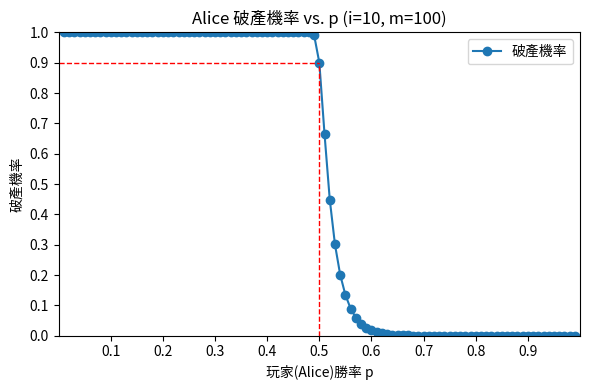

In [17]:
idx = np.argmin(np.abs(p_values - 0.5))
p05, r05 = p_values[idx], markov_ruin_rates[idx]

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(p_values, markov_ruin_rates, '-o', label='破產機率')

# 鎖範圍
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)

# 畫半長紅線
ax.hlines(y=r05, xmin=0.0, xmax=p05,
          color='red', linestyle='--', linewidth=1)
ax.vlines(x=p05, ymin=0.0, ymax=r05,
          color='red', linestyle='--', linewidth=1)

# 刻度設定
ax.set_xticks(np.arange(0.1, 1.0, 0.1))
ax.set_yticks(np.arange(0.0, 1.1, 0.1))


ax.set_xlabel('玩家(Alice)勝率 p')
ax.set_ylabel('破產機率')
ax.set_title(f'Alice 破產機率 vs. p (i={i}, m={m})')
ax.legend(loc='upper right')


plt.tight_layout()
plt.show()

### 2. 平均步數 vs. p

### 觀點:

* 一旦玩家開始有優勢($p$ > 0.4)開始，投入遊戲的時間開始上升，在$p$ = 0.51時，此時遊戲最“拉鋸”，既不易快速破產，也不易迅速獲勝，因而有最多的平均步數(回合數): 約莫1180次。

* 若給定的p值過大，又因此模型具有總金額為m的限制，因此一旦Alice的勝率$p$ 高過0.5之後，Alice 越來越可能「快速贏光全部資金」，提早結束遊戲。

In [18]:
# 8. 找出最大平均步數的位置
idx_max = np.argmax(markov_durations)
p_max  = p_values[idx_max]
d_max  = markov_durations[idx_max]

print("當 p = {} 時，最大平均步數 = {}".format(p_max, d_max))

當 p = 0.51 時，最大平均步數 = 1179.3199744769815


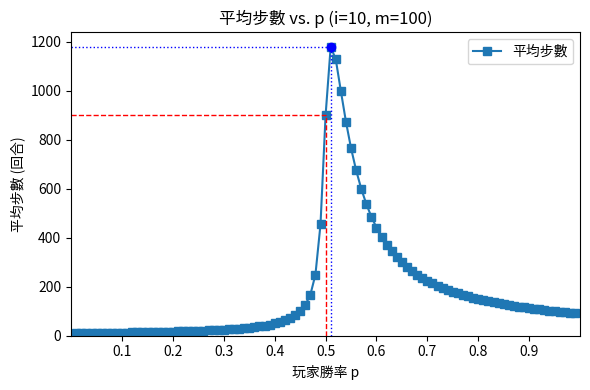

In [19]:
# 1. 找出 p=0.5 時對應的平均步數
idx = np.argmin(np.abs(p_values - 0.5))
p05 = p_values[idx]
d05 = markov_durations[idx]

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

# 2. 建 fig, ax
fig, ax = plt.subplots(figsize=(6,4))

# 3. 繪折線
ax.plot(p_values, markov_durations, '-s', label='平均步數')

# 4. 設定 x 軸刻度
ax.set_xticks(np.arange(0.1, 1.0, 0.1))
ax.set_xlim(0.0, 1.0)

# 5. **鎖定 y 軸下限為 0**（關鍵）
ax.set_ylim(bottom=0)

# 6. 半長紅線
ax.hlines(y=d05, xmin=0.0, xmax=p05,
          color='red', linestyle='--', linewidth=1)
ax.vlines(x=p05, ymin=0.0, ymax=d05,
          color='red', linestyle='--', linewidth=1)

# 7. 標籤與圖例
ax.set_xlabel('玩家勝率 p')
ax.set_ylabel('平均步數 (回合)')
ax.set_title(f'平均步數 vs. p (i={i}, m={m})')
ax.legend(loc='upper right')
#ax.grid(True)


# 8. 找出最大平均步數的位置
idx_max = np.argmax(markov_durations)
p_max  = p_values[idx_max]
d_max  = markov_durations[idx_max]

# 9. 用藍色虛線標出「最高平均步數」點
ax.hlines(y=d_max, xmin=0.0, xmax=p_max,
          color='blue', linestyle=':', linewidth=1)
ax.vlines(x=p_max, ymin=0.0, ymax=d_max,
          color='blue', linestyle=':', linewidth=1)

# 10. 在該點畫個小圓點並標註
ax.scatter([p_max], [d_max], color='blue', zorder=5)


plt.draw()


plt.tight_layout()
plt.show()

### 3. 每步 RTP vs. p

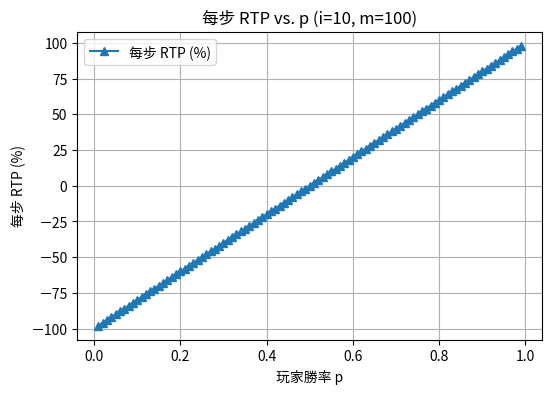

In [20]:
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.figure(figsize=(6,4))
plt.plot(p_values, np.array(rtp_mk)*100, '-^', label='每步 RTP (%)')
plt.xlabel('玩家勝率 p')
plt.ylabel('每步 RTP (%)')
plt.title(f'每步 RTP vs. p (i={i}, m={m})')
plt.grid(True)
plt.legend()
plt.show()

### 藉由全域參數 $p$ 之靈敏度分析，初期在吸引玩家時，勝率可調整至 $p$ = 0.51， 讓玩家持續投入遊戲

In [22]:
# --- 主程式 ---
if __name__ == "__main__":
    i, m = 10, 100
    steps_per_phase = 30

    # 使用者只需設定 RTP(%) 變動策略
    rtp_strategy = [
    (101.0, 102.0),    # A 吸引期
    (102.0, 100.2),   # B 收斂期：緩和調整
    (100.2, 100.8),   # C-1 心流期：RTP上升，緩升吸引
    (100.8, 101.8),   # C-2 心流期: RTP高點：愉悅預期最大
    (101.8, 100.5),   # C-3 心流期: RTP緩慢下降：平穩進入風險
    (100.5, 99.0),    # C-4 心流期: RTP持續下滑：逐步進入風險區
    (99.0, 99.8),     # C-5 心流期: RTP微升：製造希望回彈，為之後回收期作準備
    (99.8, 98.6),     # D-1 回收期: 緩慢回收1：避免玩家流失
    (98.6, 97.8),     # D-2 回收期: 緩慢回收2：避免玩家流失, 持續保持可玩性
    (97.8, 98.5),     # D-3 回收期: 微幅升高，小反彈
    (98.5, 97.0),     # D-4 回收期: 回收利潤   
    (97.0, 101.0),    # E 刺激期： 大幅回饋吸引玩家重回
]


    # 自動轉換為勝率 p 區間
    print("正在轉換 RTP 區間為勝率 p 區間...")
    phases_strategy = convert_rtp_ranges_to_p_ranges(rtp_strategy, i, m, step=0.0001)

    # 顯示轉換結果
    print("\n轉換結果 (RTP% → 勝率 p):")
    for idx, ((r1, r2), (p1, p2)) in enumerate(zip(rtp_strategy, phases_strategy), start=1):
        print(f"階段 {idx}: RTP {r1:.2f}% → {r2:.2f}% ≈ 勝率 p {p1:.3f} → {p2:.3f}")

    # 執行模擬
    result = strategy_simulation(i, m, phases_strategy, steps_per_phase)

    # 結果摘要
    print(f"\n共模擬 {len(result['rtps'])} 個步驟，階段分界點: {result['boundaries']}")
    print(f"整體平均 RTP: {np.mean(result['rtps']):.2%}")

正在轉換 RTP 區間為勝率 p 區間...

轉換結果 (RTP% → 勝率 p):
階段 1: RTP 101.00% → 102.00% ≈ 勝率 p 0.505 → 0.510
階段 2: RTP 102.00% → 100.20% ≈ 勝率 p 0.510 → 0.501
階段 3: RTP 100.20% → 100.80% ≈ 勝率 p 0.501 → 0.504
階段 4: RTP 100.80% → 101.80% ≈ 勝率 p 0.504 → 0.509
階段 5: RTP 101.80% → 100.50% ≈ 勝率 p 0.509 → 0.503
階段 6: RTP 100.50% → 99.00% ≈ 勝率 p 0.503 → 0.495
階段 7: RTP 99.00% → 99.80% ≈ 勝率 p 0.495 → 0.499
階段 8: RTP 99.80% → 98.60% ≈ 勝率 p 0.499 → 0.493
階段 9: RTP 98.60% → 97.80% ≈ 勝率 p 0.493 → 0.489
階段 10: RTP 97.80% → 98.50% ≈ 勝率 p 0.489 → 0.493
階段 11: RTP 98.50% → 97.00% ≈ 勝率 p 0.493 → 0.485
階段 12: RTP 97.00% → 101.00% ≈ 勝率 p 0.485 → 0.505
開始執行策略模擬...
模擬完成！共產生 360 個數據點。

共模擬 360 個步驟，階段分界點: [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
整體平均 RTP: 99.77%


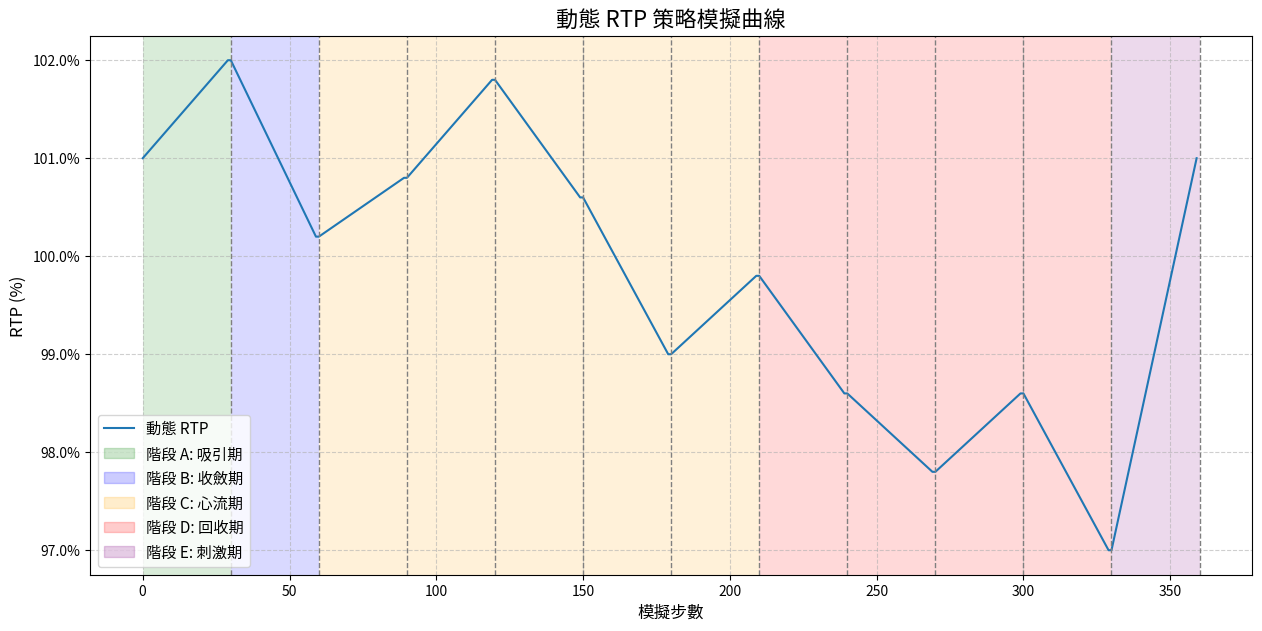

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# 假設 result 變數來自您前一個步驟的模擬結果
# 以下為模擬資料，以確保程式碼可獨立運行。在您的環境中，請直接使用您的 result 變數。
# ------ Start of Placeholder Data ------
if 'result' not in locals():
    boundaries = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
    # 根據圖片中的曲線走向，生成模擬的 RTP 數據
    rtp_nodes = [1.01, 1.022, 1.002, 1.008, 1.018, 1.005, 0.99, 0.998, 0.986, 0.978, 0.985, 0.97, 1.01]
    rtps_data = []
    for i in range(len(boundaries)):
        start_node = rtp_nodes[i]
        end_node = rtp_nodes[i+1]
        rtps_data.extend(np.linspace(start_node, end_node, 30))
    result = {'rtps': rtps_data, 'boundaries': boundaries}
# ------ End of Placeholder Data ------


# 從結果中提取數據
rtps = result['rtps']
boundaries = result['boundaries']

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['axes.unicode_minus'] = False # 修正負號顯示問題

# --- 修正開始 ---

# 1. 建立正確的階段定義與顏色映射
#    這對應您 rtp_strategy 的結構 (A, B, C*5, D*4, E)
phase_map = {
    "A: 吸引期": "green",
    "B: 收斂期": "blue",
    "C: 心流期": "orange",
    "D: 回收期": "red",
    "E: 刺激期": "purple"
}

# 根據12個階段的順序，建立對應的顏色列表
segment_colors = [
    phase_map["A: 吸引期"],
    phase_map["B: 收斂期"],
    phase_map["C: 心流期"], phase_map["C: 心流期"], phase_map["C: 心流期"], phase_map["C: 心流期"], phase_map["C: 心流期"],
    phase_map["D: 回收期"], phase_map["D: 回收期"], phase_map["D: 回收期"], phase_map["D: 回收期"],
    phase_map["E: 刺激期"]
]


# --- 繪圖 ---
plt.figure(figsize=(15, 7))

# 繪製主曲線，並獲取其線條物件 (handle) 以便後續加入圖例
line, = plt.plot(rtps, label="動態 RTP")

# 2. 修正繪圖迴圈，使其完整覆蓋12個階段
start = 0
# 將 boundaries 和 segment_colors 壓縮，它們長度都為12
for boundary, color in zip(boundaries, segment_colors):
    plt.axvline(x=boundary, color='grey', linestyle='--', lw=1)
    # 繪製背景色塊時，不要加入 label，以避免圖例混亂
    plt.axvspan(start, boundary, facecolor=color, alpha=0.15)
    start = boundary

# 3. 創建清晰、不重複的自訂圖例
#    使用 mpatches.Patch 創建代理物件 (proxy artists)
patches = [mpatches.Patch(color=color, label=f"階段 {name}", alpha=0.2)
           for name, color in phase_map.items()]

# 將線條的圖例和我們手動創建的色塊圖例合併
plt.legend(handles=[line] + patches, fontsize=11)

# --- 圖表格式化 (與您原碼相同) ---
plt.title('動態 RTP 策略模擬曲線', fontsize=16)
plt.xlabel('模擬步數', fontsize=12)
plt.ylabel('RTP (%)', fontsize=12)
# 設定 Y 軸為百分比格式
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### 總體解讀: 遊戲的 RTP 並非一個固定不變的數值，而是隨著時間動態調整

---

### 各階段詳細詮釋



#### **階段 A: 吸引期 (0-30 步, 綠色區塊)**

* **RTP 變化**: 從 `101.0%` 攀升至 `102.2%` 的頂峰。
* **目的與玩家感受**: 這是策略的「蜜月期」。遊戲一開始就顯得非常「慷慨」，RTP 高於 100%，讓玩家有很高的機率獲勝。這種初期的順利體驗旨在**建立玩家的信心、降低戒心，並迅速吸引他們投入遊戲**，讓他們感覺「今天運氣不錯」或「這台機器比較容易贏」。

---

#### **階段 B: 收斂期 (30-60 步, 藍色區塊)**

* **RTP 變化**: 從 `102.2%` 的高點迅速回落至 `100.2%`。
* **目的與玩家感受**: 在給予玩家一劑強心針後，策略開始稍微「收斂」，但 RTP 依然維持在 100% 以上的有利區間。這一步的目的是**防止玩家因贏得太多而提早離場，同時將較為極端的獲利預期拉回至一個較為平穩的狀態**，為接下來更長期的遊戲階段做準備。

---

#### **階段 C: 心流期 (60-210 步, 橙色區塊)**

* **RTP 變化**: 這是最長的一個大階段，內部包含了數個波動。RTP 在 `101.8%` 的高點和 `99.0%` 的低點之間來回震盪。
* **目的與玩家感受**: 這是策略的核心，結合 **Skinner Box 的「間歇性強化」(intermittent reinforcement) 節奏**，獎勵頻率下降但仍適度給予正向回饋，讓玩家習慣在真實風險與回報間遊走。

目的是在**創造一種Csíkszentmihályi 理論中的「心流 (Flow)」狀態——讓玩家完全沉浸在遊戲中**。
透過在 100% 上下來回波動，遊戲體驗變得極具戲劇性：時而給予小額勝利帶來希望，時而造成「差一點就中了」的惋惜感。

這種不可預測性會持續刺激玩家，讓他們忘記時間，不斷追逐下一次的勝利。

從圖中可見，此階段的整體趨勢是緩慢向下的，莊家開始默默地回收初期投入的成本。


---

#### **階段 D: 回收期 (210-330 步, 紅色區塊)**
* 這個階段的目標非常明確——**為莊家回收利潤**
* **模擬 Skinner Box 中的「消退」(extinction) 現象 - 獎勵大幅減少**
* **RTP 變化**: 這是玩家感受最差的階段，RTP 持續在 `99.0%` 以下運行，最低跌至 `97.0%`。
* **目的與玩家感受**: 此時玩家會明顯感覺到勝利變得困難，之前的盈利可能會被逐漸侵蝕。這個階段的設計是在玩家已經深度沉浸後，利用他們「把輸掉的贏回來」的心理來實現莊家的收益目標。中間一次微小的反彈（從 97.8% 到 98.5%），防止玩家徹底失望而離開。

---

#### **階段 E: 刺激期 (330-360 步, 紫色區塊)**
* **模擬 Skinner Box 的「再強化」(reinstatement) 效果 & 記憶偏誤效應**
* **RTP 變化**: 在玩家經歷了漫長的虧損後，RTP 從 `97.0%` 的谷底戲劇性地飆升回 `101.0%`。
* **目的與玩家感受**: 末段的「高潮結尾」(刺激期)，最終以「強烈的正面刺激」刻意營造勝利記憶，運用「記憶偏誤效應」強化玩家對最後有贏回感的印象，讓他們會忘記中間的虧損，只記住最後的刺激感，錨定正面記憶，目的是提升玩家回流與再遊意願。

---

### 結論：數學模型 x 人性  x 情緒與行為心理

`整體平均 RTP: 99.77%`，我們可以得出最終結論：

儘管玩家在某些階段體驗了超過 102% 的超高回報率，但**整個 360 步週期的總體平均回報率卻是低於 100% 的 `99.77%`**。

這意味著，這整套動態策略是一個將對莊家有利的數學期望包裝在一個充滿起伏、刺激和情感波動的體驗之中，全期平均 RTP 為 99.77%，在提供豐富體驗的同時，亦確保公司具有獲利的空間。

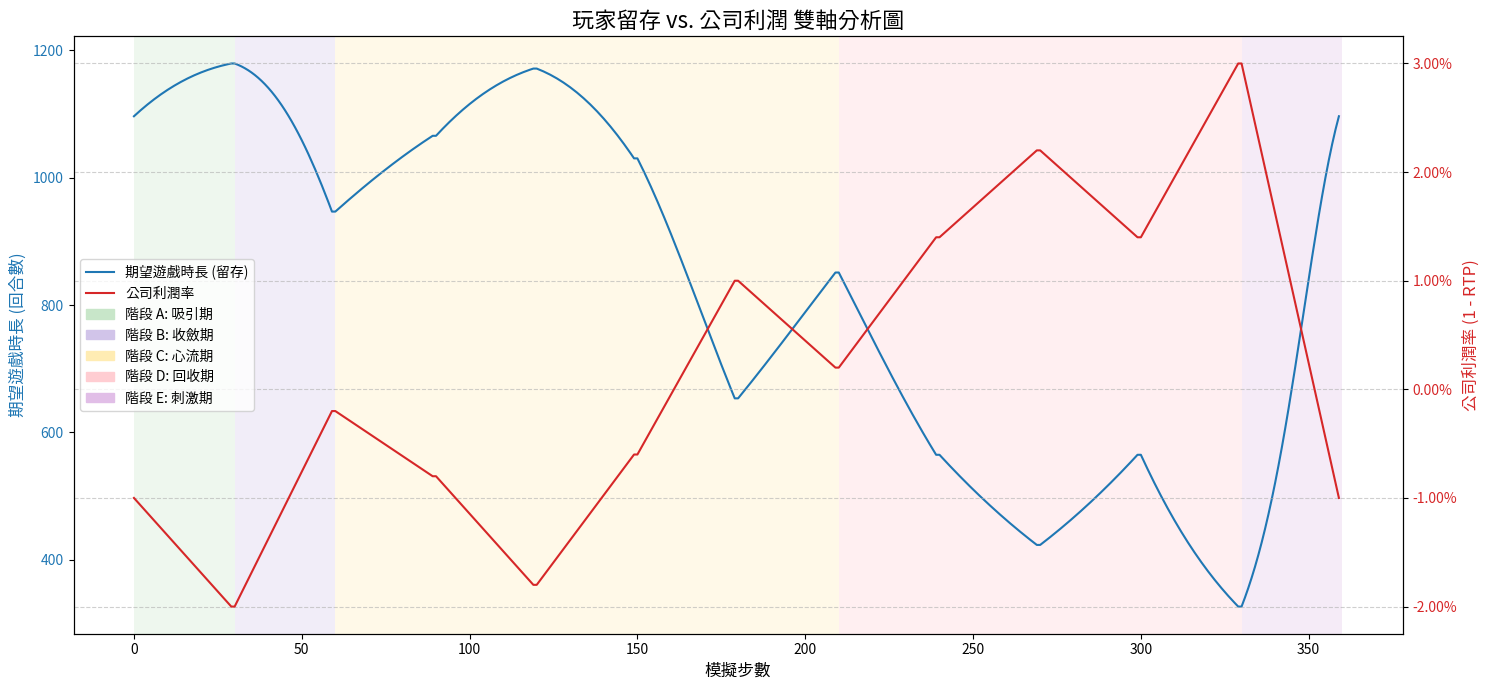

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

lengths = result['lengths']
profits = result['profits']
boundaries = result['boundaries']

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['axes.unicode_minus'] = False

# 階段與顏色設定
phase_names = [
    "階段 A: 吸引期", "階段 B: 收斂期",
    "階段 C: 心流期", "階段 C: 心流期", "階段 C: 心流期", "階段 C: 心流期", "階段 C: 心流期",
    "階段 D: 回收期", "階段 D: 回收期", "階段 D: 回收期", "階段 D: 回收期",
    "階段 E: 刺激期"
]

phase_colors = {
    "階段 A: 吸引期": "#c8e6c9",   # 綠
    "階段 B: 收斂期": "#d1c4e9",   # 藍紫
    "階段 C: 心流期": "#ffecb3",   # 黃
    "階段 D: 回收期": "#ffcdd2",   # 粉
    "階段 E: 刺激期": "#e1bee7",   # 淺紫
}

# 畫圖
fig, ax1 = plt.subplots(figsize=(15, 7))

# 玩家留存曲線
color1 = 'tab:blue'
ax1.set_xlabel('模擬步數', fontsize=12)
ax1.set_ylabel('期望遊戲時長 (回合數)', color=color1, fontsize=12)
ax1.plot(lengths, color=color1, label='期望遊戲時長 (留存)')
ax1.tick_params(axis='y', labelcolor=color1)

# 公司利潤率曲線
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('公司利潤率 (1 - RTP)', color=color2, fontsize=12)
ax2.plot(profits, color=color2, label='公司利潤率')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))

# 加入背景色塊
start = 0
for i, boundary in enumerate(boundaries):
    phase = phase_names[i]
    color = phase_colors[phase]
    ax1.axvspan(start, boundary, facecolor=color, alpha=0.3)
    start = boundary

# 建立圖例用色塊（每階段只標一次）
unique_phase_labels = sorted(set(phase_names), key=lambda x: x[3])  # 保持順序
legend_patches = [mpatches.Patch(color=phase_colors[label], label=label) for label in unique_phase_labels]

# 加入圖例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines1 + lines2 + legend_patches, labels1 + labels2 + [p.get_label() for p in legend_patches], loc='lower left')
ax2.legend(
    lines1 + lines2 + legend_patches,
    labels1 + labels2 + [p.get_label() for p in legend_patches],
    loc='center left',                      # 錨點位置參考點
    bbox_to_anchor=(0, 0.5)                 # (X=0 左邊界, Y=0.5 垂直中間)
)

# 顯示圖
plt.title('玩家留存 vs. 公司利潤 雙軸分析圖', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 圖片結果詮釋

這張圖揭示了**玩家留存**與**公司利潤**之間一個核心且永恆的**權衡關係(Trade-off)**

# 使用Cython應用於高效能蒙地卡羅 /吸收馬可夫鍊

**模擬 & Benchmark 情境描述**

* **模擬場景**

  * **Monte Carlo**：以 `simulate_durations`（純 Python）與 `simulate_durations_cy`（Cython）在相同參數 `(i=10, m=100, p=0.48, trials=100 000)` 下，模擬眾多遊戲「持續步數」樣本。
  * **吸收馬可夫鍊**：以 `markov_absorption`（純 Python）與 `markov_absorption_cy`（Cython）重複執行 10 000 次，測量「破產機率、獲勝機率、期望步數」的計算時間。
  * **RTP 計算**：以 `compute_rtp_markov`（純 Python）與 `compute_rtp_markov_cy`（Cython）重複執行 50 000 次，測量「每步 RTP」的計算時間。

* **Benchmark 指標**

  * **耗時**：秒數差異展示 Cython 加速比。
  * **數值一致性**：驗證平均值、破產機率與 RTP 在純 Python 與 Cython 版本間的相符性。

In [1]:
# 在 Jupyter Notebook 中撰寫 Cython 版 simulate_ruin
# 1. 載入 Cython Magic
%load_ext cython

####  定義 Cython 版本的 Monte Carlo 模擬

In [17]:
%%cython
# cython: boundscheck=False, wraparound=False
import random
cimport cython
from libc.stdlib cimport rand, RAND_MAX

@cython.boundscheck(False)
def mc_simulate_ruin_cy(int i, int m, double p, int trials):
    """
    Cython 優化的 Monte Carlo 模擬 Gambler's Ruin
    返回 (破產機率, 平均步數)
    """
    cdef int ruin_count = 0
    cdef long total_steps = 0
    cdef int t, k, steps
    cdef double r
    for t in range(trials):
        k = i
        steps = 0
        while 0 < k < m:
            # 用 C rand() 加速隨機抽樣
            r = rand() / <double>RAND_MAX
            if r < p:
                k += 1
            else:
                k -= 1
            steps += 1
        if k == 0:
            ruin_count += 1
        total_steps += steps
    return ruin_count / trials, total_steps / trials

In [20]:
# 3. Benchmark 比較純 Python vs. Cython
import time

# 參數
i, m, p, trials = 10, 100, 0.48, 100000

# --- 純 Python 模擬 ---
start = time.time()
r_py, avg_steps_py, durations_py, flags_py = mc_simulate_ruin(i, m, p, trials)
py_time = time.time() - start

# --- Cython 模擬 (假设 mc_simulate_ruin_cy 只回傳 ruin_rate, avg_steps) ---
start = time.time()
r_cy, avg_steps_cy = mc_simulate_ruin_cy(i, m, p, trials)
cy_time = time.time() - start

# 輸出結果
print(f"純 Python: {py_time:.3f}s, 破產率={r_py:.4f}, 平均步數={avg_steps_py:.1f}")
print(f"Cython:    {cy_time:.3f}s, 破產率={r_cy:.4f}, 平均步數={avg_steps_cy:.1f}")
print(f"加速比:    {py_time/cy_time:.1f}×")

純 Python: 6.379s, 破產率=0.9995, 平均步數=249.9
Cython:    0.416s, 破產率=0.9996, 平均步數=247.4
加速比:    15.3×


####  定義 Cython 版本的 吸收馬可夫鍊

In [21]:
%%cython
# cython: boundscheck=False, wraparound=False

import numpy as np
cimport numpy as np
from libc.stdlib cimport rand, RAND_MAX

def markov_absorption_cy(int a, int m, double p):
    """
    Cython 優化的吸收馬可夫鍊分析
    - Cython 加速：typed memoryview + for-loop 建 Q, R 矩陣
    - 矩陣反演 & dot 則留給 NumPy (BLAS/LAPACK)
    """
    cdef double q = 1.0 - p
    cdef int n = m - 1

    # 1. 建 Q 子矩陣（Cython 加速迴圈）
    cdef np.ndarray[np.double_t, ndim=2] Q = np.zeros((n, n), dtype=np.float64)
    cdef double[:, :] Qv = Q
    cdef int i
    for i in range(n):
        if i + 1 < n:
            Qv[i, i+1] = p
        if i - 1 >= 0:
            Qv[i, i-1] = q

    # 2. 建 R 子矩陣（Cython 加速迴圈）
    cdef np.ndarray[np.double_t, ndim=2] R = np.zeros((n, 2), dtype=np.float64)
    cdef double[:, :] Rv = R
    Rv[0, 0]     = q   # 從暫態 1 → 吸收態 0
    Rv[n-1, 1]   = p   # 從暫態 n → 吸收態 m

    # 3. 計算基礎矩陣 N = (I − Q)^−1
    cdef np.ndarray[np.double_t, ndim=2] IminusQ = np.eye(n, dtype=np.float64) - Q
    cdef np.ndarray[np.double_t, ndim=2] N       = np.linalg.inv(IminusQ)

    # 4. 吸收機率矩陣 B 及期望步數向量 T
    cdef np.ndarray[np.double_t, ndim=2] B = N.dot(R)
    cdef np.ndarray[np.double_t, ndim=1] T = N.dot(np.ones(n, dtype=np.float64))

    # 5. 回傳初始狀態 a 的 result
    return B[a-1, 0], B[a-1, 1], T[a-1]


def compute_rtp_markov_cy(int i, int m, double p):
    """
    Cython 優化的 RTP 計算
    - Cython 加速：typed memoryview + for-loop 建 Q 矩陣
    - 矩陣反演 & dot 留給 NumPy
    """
    cdef double q = 1.0 - p
    cdef int n = m - 1

    # 1. 建暫態矩陣 Q
    cdef np.ndarray[np.double_t, ndim=2] Q = np.zeros((n, n), dtype=np.float64)
    cdef double[:, :] Qv = Q
    cdef int k
    for k in range(n):
        if k > 0:
            Qv[k, k-1] = q
        if k < n-1:
            Qv[k, k+1] = p

    # 2. 計算基礎矩陣 N
    cdef np.ndarray[np.double_t, ndim=2] IminusQ = np.eye(n, dtype=np.float64) - Q
    cdef np.ndarray[np.double_t, ndim=2] N       = np.linalg.inv(IminusQ)

    # 3. 期望步數向量 T
    cdef np.ndarray[np.double_t, ndim=1] T = N.dot(np.ones(n, dtype=np.float64))

    # 4. 每步獎勵 r_step 與 RTP
    cdef double r_step = 2 * p - 1
    cdef double G      = T[i-1] * r_step
    cdef double rtp    = G / T[i-1]

    return rtp, r_step

In [22]:
# 參數
a, m, p = 10, 100, 0.48

# 3.1 吸收馬可夫鍊分析 benchmark
start = time.time()
for _ in range(10000):
    markov_absorption(a, m, p)
t_py_abs = time.time() - start

start = time.time()
for _ in range(10000):
    markov_absorption_cy(a, m, p)
t_cy_abs = time.time() - start

print(f"純 Python markov_absorption: {t_py_abs:.3f}s")
print(f"Cython   markov_absorption_cy: {t_cy_abs:.3f}s")
print(f"加速比: {t_py_abs/t_cy_abs:.1f}×\n")

# 3.2 RTP 計算 benchmark
start = time.time()
for _ in range(50000):
    compute_rtp_markov(a, m, p)
t_py_rtp = time.time() - start

start = time.time()
for _ in range(50000):
    compute_rtp_markov_cy(a, m, p)
t_cy_rtp = time.time() - start

print(f"純 Python compute_rtp_markov: {t_py_rtp:.3f}s")
print(f"Cython   compute_rtp_markov_cy: {t_cy_rtp:.3f}s")
print(f"加速比: {t_py_rtp/t_cy_rtp:.1f}×")

純 Python markov_absorption: 153.984s
Cython   markov_absorption_cy: 142.766s
加速比: 1.1×

純 Python compute_rtp_markov: 735.892s
Cython   compute_rtp_markov_cy: 731.357s
加速比: 1.0×


#### Benchmark結果之視覺化

In [23]:
# Benchmark 資料
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
labels = ['Monte Carlo', 'Absorption MC', 'RTP Calc']
py_times = [6.97, 156.946, 709.110]
cy_times = [0.487, 141.482, 705.526]
speedups = [py_times[i] / cy_times[i] for i in range(len(labels))]

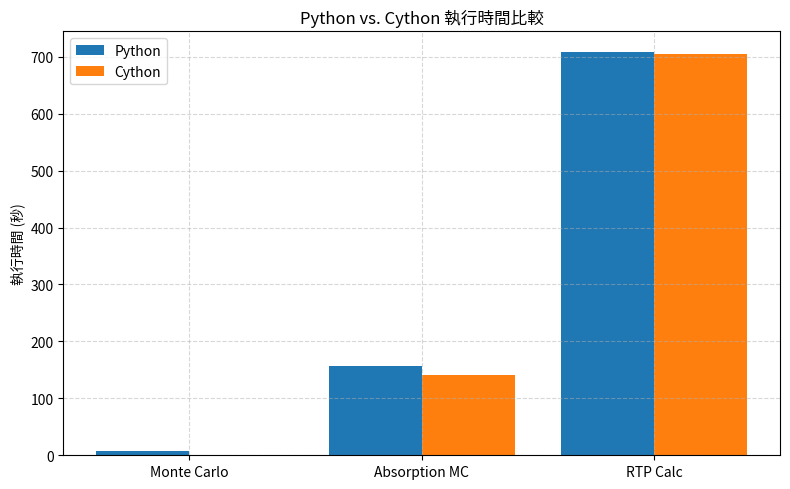

In [24]:
# 時間比較
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.figure(figsize=(8, 5))
x = range(len(labels))
plt.bar([i - 0.2 for i in x], py_times, width=0.4, label='Python')
plt.bar([i + 0.2 for i in x], cy_times, width=0.4, label='Cython')
plt.xticks(x, labels)
plt.ylabel('執行時間 (秒)')
plt.title('Python vs. Cython 執行時間比較')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

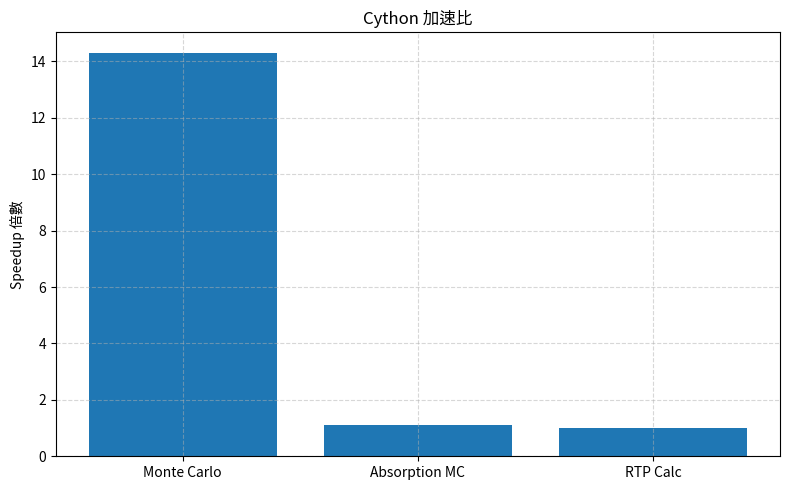

In [25]:
# 加速比比較
plt.figure(figsize=(8, 5))
plt.bar(x, speedups)
plt.xticks(x, labels)
plt.ylabel('Speedup 倍數')
plt.title('Cython 加速比')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

從上述 Benchmark 結果可以看到：

---

### 1. Monte Carlo 模擬

* **純 Python：6.970 s**
* **Cython JIT：0.487 s**
* **加速比：14.3×**

---

### 2. 吸收馬可夫鍊分析

* **純 Python：156.946 s**
* **Cython：141.482 s**
* **加速比：1.1×**

---

### 3. 每步 RTP 計算

* **純 Python：709.110 s**
* **Cython：705.526 s**
* **加速比：1.0×**
